<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [0]:
import warnings
warnings.filterwarnings("ignore")
import csv, datetime, time, math, pickle, os, pdb, gc
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds, eigs
import matplotlib.pylab as plt
import seaborn as sns#Plots
import networkx as nx
from tqdm import tqdm

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# 1. Reading Preprocessed Data

In [3]:
d = '/content/drive/My Drive/Colab Notebooks/Datasets/Case_Study/Facebook friend recommendation/'
df_train = pd.read_csv(d+'final_train.csv')
df_cv    = pd.read_csv(d+'final_cv.csv')
df_test  = pd.read_csv(d+'final_test.csv')
print('Shape of train data: ', df_train.shape)
print('Shape of CV data   : ', df_train.shape)
print('Shape of test data : ',df_test.shape)
df_train.columns

Shape of train data:  (1000001, 59)
Shape of CV data   :  (1000001, 59)
Shape of test data :  (50001, 59)


Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'preferntial_attachment', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6', 'svd_u_s_d',
       'svd_v_s_d', 'svd_u_v_s', 'svd_u_v_d'],
      dtype='object')

In [4]:
y_train = df_train['indicator_link'].values
y_cv    = df_cv['indicator_link'].values
y_test  = df_test['indicator_link'].values
df_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_cv.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
print('Shape of train data: ', df_train.shape)
print('Shape of test data: ', df_test.shape)

Shape of train data:  (1000001, 56)
Shape of test data:  (50001, 56)


**Let's change data from dataframe to numpynd array and Standardize them**

In [5]:
x_train = df_train.values
x_cv    = df_cv.values
x_test  = df_test.values

std = StandardScaler()
x_train = std.fit_transform(x_train)
x_cv    = std.transform(x_cv)
x_test  = std.transform(x_test)

print('Shape of train data: ', x_train.shape)
print('Shape of CV data   : ', x_cv.shape)
print('Shape of test data : ', x_test.shape)

Shape of train data:  (1000001, 56)
Shape of CV data   :  (25001, 56)
Shape of test data :  (50001, 56)


# 2. Machine Learning Models

## Some Inportant Functions

### For plots

In [0]:
def plot_confusion_matrices(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred) #for confusion matrix
    # for presion matrix: take the sum column wise, i.e. column normalization
    P = C/C.sum(axis = 0)
    #for recall matrix: take the sum row wise, i.e. row normalization
    R = (C.T/C.sum(axis = 1)).T
    
    fig = plt.figure(figsize=(18,4))
    
    for i, j in enumerate(zip([C,P,R], ['Confusion', 'Precison', 'Recall'])):
        ax = fig.add_subplot(1,3,i+1)
        if i == 0:
            fmts = 'd'
        else:
            fmts = '0.3f'
        #https://seaborn.pydata.org/generated/seaborn.heatmap.html
        sns.heatmap(j[0], annot = True, fmt = fmts, annot_kws={"size":15})
        plt.xlabel('Predicted Class', fontsize = 12)
        plt.ylabel('Original Class', fontsize = 12)
        plt.title(str(j[1])+' '+'Matrix', fontsize = 15)
    
    plt.show()

In [0]:
def score_plot(train_error, cv_error, hyp_vals, hyp_name = 'log10(alpha)'):
    plt.figure(figsize = (10,6))
    plt.plot(hyp_vals, train_error, 'o-',label = 'Train')
    plt.plot(hyp_vals, cv_error, 'o-',label = 'CV')
    plt.title('f1-score vs {} (hyperparameter)'.format(hyp_name), fontsize = 15)
    plt.xlabel(hyp_name, fontsize = 12)
    plt.ylabel('f1-score', fontsize = 12)
    plt.grid()
    plt.legend(fontsize = 12)
    plt.show()

In [0]:
def score_heatmap_plot(train_score, cv_score):
    fig = plt.figure(figsize=(20,6))
    ax1 = fig.add_subplot(1,2,1)
    ax1 = sns.heatmap(train_score, annot = True, fmt = '0.3f', annot_kws={"size":15})
    plt.ylabel('estimators', fontsize = 12)
    plt.xlabel('depth', fontsize = 12)
    plt.title('For Train Data\nf1-score values for (estimator, depth) pair', fontsize = 15)  

    ax2 = fig.add_subplot(1,2,2)
    ax2 = sns.heatmap(cv_score, annot = True, fmt = '0.3f', annot_kws={"size":15})
    plt.ylabel('estimators', fontsize = 12)
    plt.xlabel('depth', fontsize = 12)
    plt.title('For CV Data\nf1-score values for (estimator, depth) pair', fontsize = 15)
    plt.show()

In [0]:
def plot_roc_curve(fpr, tpr, auc, fpr1, tpr1, auc1):
    plt.figure(figsize = (8,6))
    plt.title('Receiver Operating Characteristic', fontsize = 15)
    plt.plot(fpr, tpr, 'b-', label = 'Train AUC = ' + str(auc))
    plt.plot(fpr1, tpr1, 'g-', label = 'Test AUC = ' + str(auc1))
    plt.legend(loc = 'lower right', prop={'size': 12}) #to increase the font size of legend: https://stckoverflow.com/a/7125157
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('False Positive Rate', fontsize = 12)
    plt.ylabel('True Positive Rate', fontsize = 12)
    plt.grid('on')
    plt.show()

### For tunning

In [0]:
def sgd_tuning(X_train, Y_train, X_cv, Y_cv, loss_name):
    alpha = [10 ** x for x in range(-7, 5)] # hyperparam for SGD classifier.    
    cv_score    = []
    train_score = []
    
    for j,i in enumerate(alpha):
        clf = SGDClassifier(alpha = i, penalty ='l2', loss = loss_name, random_state=42)
        clf.fit(X_train, Y_train)

        cv_score.append(f1_score(Y_cv, clf.predict(X_cv)))
        train_score.append(f1_score(Y_train, clf.predict(X_train)))
        
        print("For values of alpha = {}, Train f1 score: {} and CV f1 score: {}".format(i, round(train_score[j],4), round(cv_score[j],4)))

    print()
    # let's plot the errors
    score_plot(train_score, cv_score, hyp_vals = np.log10(alpha), hyp_name = 'log10(alpha)')
    # this will give best alpha value, but validate with the plot
    best_alpha = alpha[np.argmax(cv_score)]
    print('Best alpha value is:', best_alpha,',But need validation form plot!')
    
    return cv_score, best_alpha

In [0]:
def DT_tunning(X_train, Y_train, X_cv, Y_cv):
    depths = [2, 5, 8, 10, 15, 20, 25, 30, 40, 50, 80, 100]
    cv_score    = []
    train_score = []
    for i, depth in enumerate(depths):
        clf = DecisionTreeClassifier(criterion = 'gini', max_depth = depth, random_state = 42)
        clf.fit(X_train, Y_train)
        
        cv_score.append(f1_score(Y_cv, clf.predict(X_cv)))
        train_score.append(f1_score(Y_train, clf.predict(X_train)))
        
        print("For values of max_depth = {}, Train f1 score: {} and CV f1 score: {}"
              .format(depth, round(train_score[i],4), round(cv_score[i],4)))

    print()
    # let's plot the errors
    score_plot(train_score, cv_score, hyp_vals = depths, hyp_name = 'max_depth')
    # this will give best alpha value, but validate with the plot
    best_depth = depths[np.argmax(cv_score)]
    print('Best depth value is:', best_depth,',But need validation form plot!')
    
    return cv_score, best_depth

In [0]:
def tune_RF(X_train, Y_train, X_cv, Y_cv):
    estimators = np.array([10, 50, 100, 200, 300, 400, 500]) #estimators
    depths = np.array([2, 4, 6, 8, 10, 12])# depths
    
    try:
        train_score = pd.read_csv(d+'tunned_rf_train.csv')
        cv_score    = pd.read_csv(d+'tunned_rf_cv.csv')
        train_score.index, train_score.columns = estimators, depths
        cv_score.index, cv_score.columns       = estimators, depths 
    except:
        train_score = pd.DataFrame(data = np.zeros((len(estimators), len(depths))), index = estimators, columns = depths)
        cv_score    = pd.DataFrame(data = np.zeros((len(estimators), len(depths))), index = estimators, columns = depths)

    for est in estimators:
        for depth in depths:
            if train_score.loc[est,depth] == 0 and cv_score.loc[est,depth] == 0: 
                print('Training for: n_estimators = {}, max_depth = {}'.format(est, depth))

                # scikit-learn API: https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMClassifier
                clf = RandomForestClassifier(max_depth = depth, n_estimators= est, random_state = 42)
                clf.fit(X_train, Y_train)

                # finding the log-loss value
                train_score.loc[est,depth] = f1_score(Y_train, clf.predict(X_train))
                cv_score.loc[est,depth]    = f1_score(Y_cv, clf.predict(X_cv))

                # save the value in each iteration
                train_score.to_csv(d+'tunned_rf_train.csv', index=False)
                cv_score.to_csv(d+'tunned_rf_cv.csv', index=False)
     
    score_heatmap_plot(train_score, cv_score)

**I'll use LighGBM to train GBDT and RF model**
* Ref.: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc


In [0]:
def tune_GBDT(X_train, Y_train, X_cv, Y_cv, boosting_type1 = 'gbdt'):
    estimators = np.array([10, 50, 100, 200, 300, 400, 500]) #estimators
    depths = np.array( [2, 4, 6, 8, 10, 12])# depths
    
    try:
        train_score = pd.read_csv(d+'tunned_gbdt_train.csv')
        cv_score    = pd.read_csv(d+'tunned_gbdt_cv.csv')
        train_score.index, train_score.columns = estimators, depths
        cv_score.index, cv_score.columns       = estimators, depths 
    except:
        train_score = pd.DataFrame(data = np.zeros((len(estimators), len(depths))), index = estimators, columns = depths)
        cv_score    = pd.DataFrame(data = np.zeros((len(estimators), len(depths))), index = estimators, columns = depths)
    
    for est in estimators:
        for depth in depths:
            if train_score.loc[est,depth] == 0 and cv_score.loc[est,depth] == 0: 
                print('Training for: n_estimators = {}, max_depth = {}'.format(est, depth))

                # scikit-learn API: https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.LGBMClassifier
                clf = LGBMClassifier(boosting_type = boosting_type1, max_depth = depth, n_estimators= est, random_state = 42)
                clf.fit(X_train, Y_train)

                # finding the log-loss value
                train_score.loc[est,depth] = f1_score(Y_train, clf.predict(X_train))
                cv_score.loc[est,depth]    = f1_score(Y_cv, clf.predict(X_cv))

                # save the value in each iteration
                train_score.to_csv(d+'tunned_gbdt_train.csv', index=False)
                cv_score.to_csv(d+'tunned_gbdt_cv.csv', index=False)
     
    score_heatmap_plot(train_score, cv_score)

In [0]:
def report_classifier(clf, X_train, Y_train, X_cv, Y_cv, X_test, Y_test):
    clf.fit(X_train, Y_train)
    
    y_train_pred = clf.predict(X_train)
    y_cv_pred    = clf.predict(X_cv)
    y_test_pred  = clf.predict(X_test)
    
    train_score = round(f1_score(Y_train, y_train_pred),4)
    cv_score    = round(f1_score(Y_cv, y_cv_pred),4)
    test_score  = round(f1_score(Y_test, y_test_pred),4)

    print('f1-score for train:{}, CV:{} and Test:{}'.format(train_score, cv_score, test_score))

    #Plot only confusion matrix of
    print('For train data')
    plot_confusion_matrices(Y_train, y_train_pred)    
    print('For CV data')
    plot_confusion_matrices(Y_cv, y_cv_pred)    
    print('For test data')
    plot_confusion_matrices(Y_test, y_test_pred)
    print('\n')
    
    return train_score, cv_score, test_score, clf


In [0]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Train f1-score", "CV f1-score", "Test f1-score", "Train AUC", "Test AUC"]

## 2.1 Logistic Regression

For values of alpha = 1e-07, Train f1 score: 0.9011 and CV f1 score: 0.8662
For values of alpha = 1e-06, Train f1 score: 0.9295 and CV f1 score: 0.906
For values of alpha = 1e-05, Train f1 score: 0.9299 and CV f1 score: 0.9061
For values of alpha = 0.0001, Train f1 score: 0.9213 and CV f1 score: 0.9122
For values of alpha = 0.001, Train f1 score: 0.9171 and CV f1 score: 0.9091
For values of alpha = 0.01, Train f1 score: 0.9157 and CV f1 score: 0.8905
For values of alpha = 0.1, Train f1 score: 0.9052 and CV f1 score: 0.8641
For values of alpha = 1, Train f1 score: 0.8741 and CV f1 score: 0.8336
For values of alpha = 10, Train f1 score: 0.5943 and CV f1 score: 0.5722
For values of alpha = 100, Train f1 score: 0.0178 and CV f1 score: 0.0185
For values of alpha = 1000, Train f1 score: 0.0 and CV f1 score: 0.0
For values of alpha = 10000, Train f1 score: 0.0 and CV f1 score: 0.0



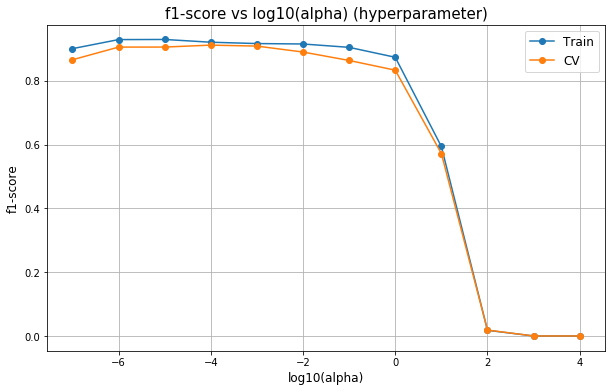

Best alpha value is: 0.0001 ,But need validation form plot!


In [16]:
cv_error, best_hyp = sgd_tuning(x_train, y_train, x_cv, y_cv, loss_name = 'log')

f1-score for train:0.9213, CV:0.9122 and Test:0.9116
For train data


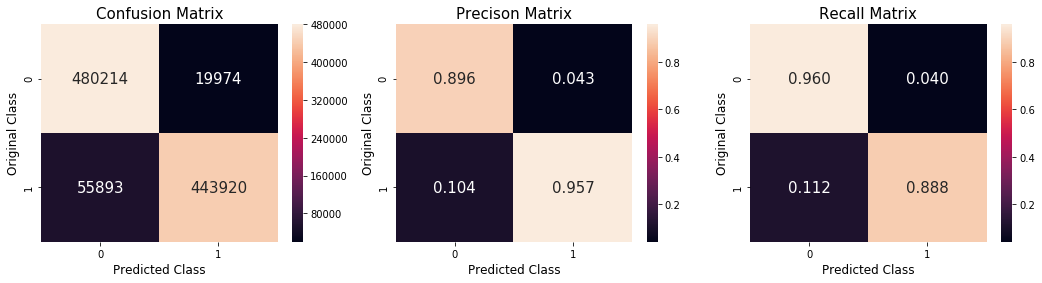

For CV data


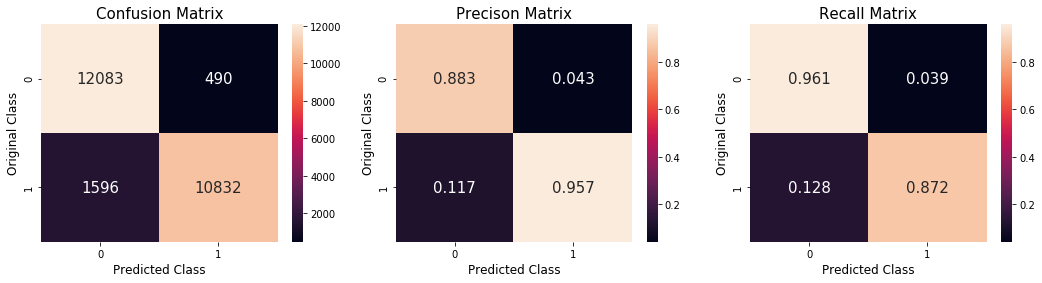

For test data


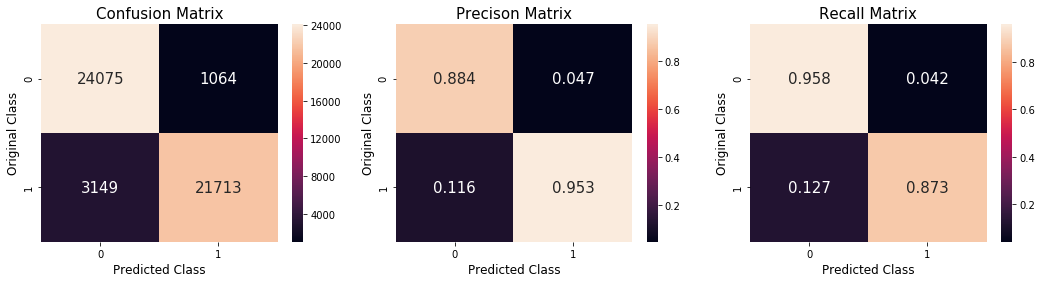

In [17]:
best_alpha = best_hyp
clf = SGDClassifier(alpha = best_alpha, penalty ='l2', loss = 'log', random_state=42)
train_score, cv_score, test_score, clf = report_classifier(clf, x_train, y_train, x_cv, y_cv, x_test, y_test)

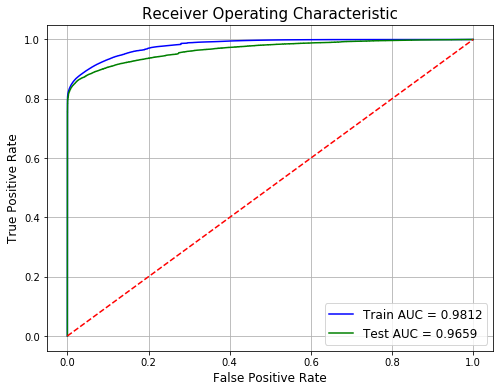

In [18]:
fpr_train, tpr_train, ths_train = roc_curve(y_train, clf.predict_proba(x_train)[:,1])
auc_train = round(auc(fpr_train, tpr_train),4)

fpr_test, tpr_test, ths_test = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
auc_test = round(auc(fpr_test, tpr_test),4)

table.add_row(['Logistic Regression', train_score, cv_score, test_score, auc_train, auc_test])
plot_roc_curve(fpr_train, tpr_train, auc_train, fpr_test, tpr_test, auc_test)

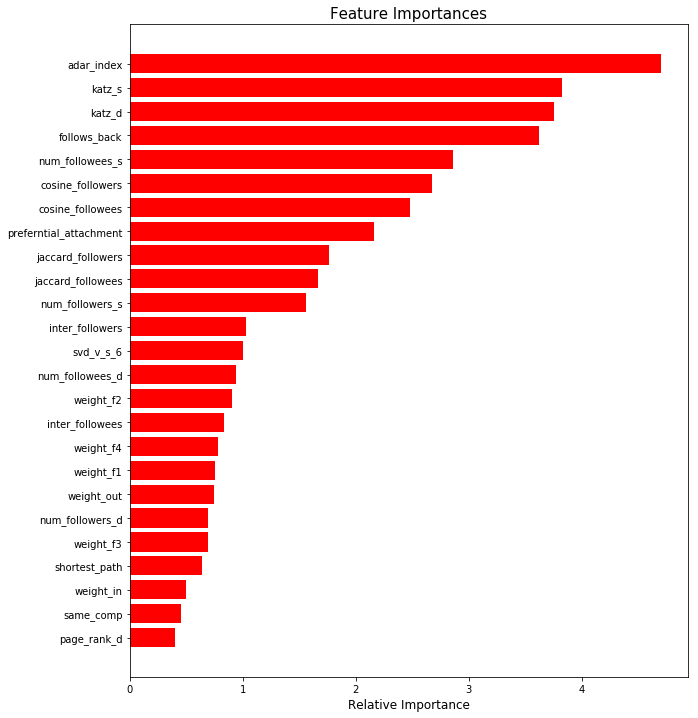

In [19]:
features = df_train.columns
importances = np.abs(clf.coef_)[0]
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances', fontsize = 15)
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance', fontsize = 12)
plt.show()

## 2.2 Linear SVM

For values of alpha = 1e-07, Train f1 score: 0.9196 and CV f1 score: 0.9117
For values of alpha = 1e-06, Train f1 score: 0.9202 and CV f1 score: 0.9129
For values of alpha = 1e-05, Train f1 score: 0.9256 and CV f1 score: 0.9121
For values of alpha = 0.0001, Train f1 score: 0.921 and CV f1 score: 0.9138
For values of alpha = 0.001, Train f1 score: 0.9164 and CV f1 score: 0.9108
For values of alpha = 0.01, Train f1 score: 0.9157 and CV f1 score: 0.9103
For values of alpha = 0.1, Train f1 score: 0.9136 and CV f1 score: 0.8887
For values of alpha = 1, Train f1 score: 0.8866 and CV f1 score: 0.846
For values of alpha = 10, Train f1 score: 0.5374 and CV f1 score: 0.519
For values of alpha = 100, Train f1 score: 0.0187 and CV f1 score: 0.0198
For values of alpha = 1000, Train f1 score: 0.0 and CV f1 score: 0.0
For values of alpha = 10000, Train f1 score: 0.0 and CV f1 score: 0.0



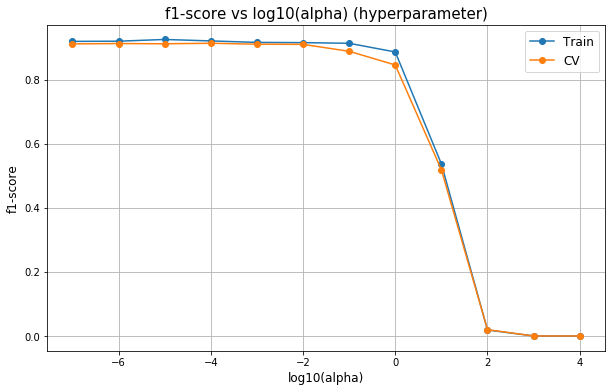

Best alpha value is: 0.0001 ,But need validation form plot!


In [20]:
cv_error, best_hyp = sgd_tuning(x_train, y_train, x_cv, y_cv, loss_name = 'hinge')

f1-score for train:0.921, CV:0.9138 and Test:0.9139
For train data


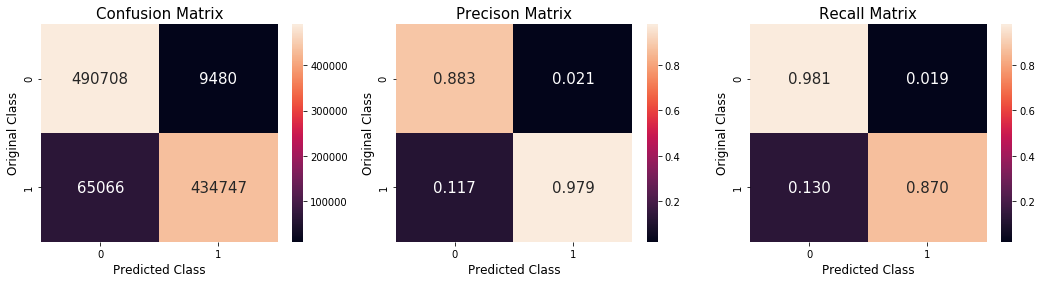

For CV data


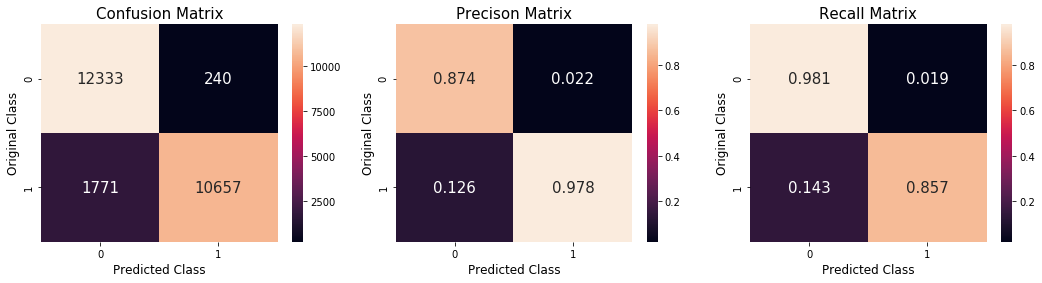

For test data


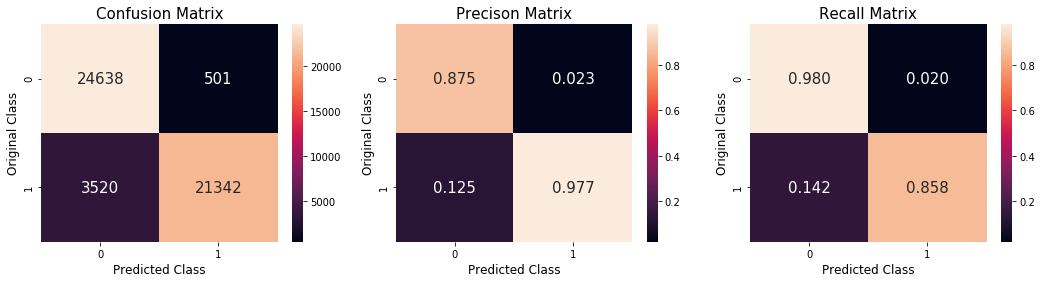

In [21]:
best_alpha = best_hyp
clf = SGDClassifier(alpha = best_alpha, penalty ='l2', loss = 'hinge', random_state=42)
train_score, cv_score, test_score, clf = report_classifier(clf, x_train, y_train, x_cv, y_cv, x_test, y_test)

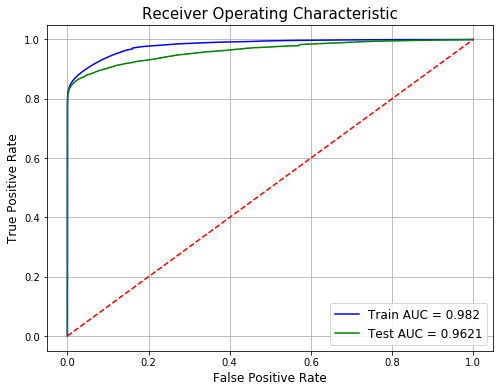

In [22]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier.decision_function
fpr_train, tpr_train, ths_train = roc_curve(y_train, clf.decision_function(x_train))
auc_train = round(auc(fpr_train, tpr_train),4)

fpr_test, tpr_test, ths_test = roc_curve(y_test, clf.decision_function(x_test))
auc_test = round(auc(fpr_test, tpr_test),4)

table.add_row(['Linear SVM', train_score, cv_score, test_score, auc_train, auc_test])
plot_roc_curve(fpr_train, tpr_train, auc_train, fpr_test, tpr_test, auc_test)

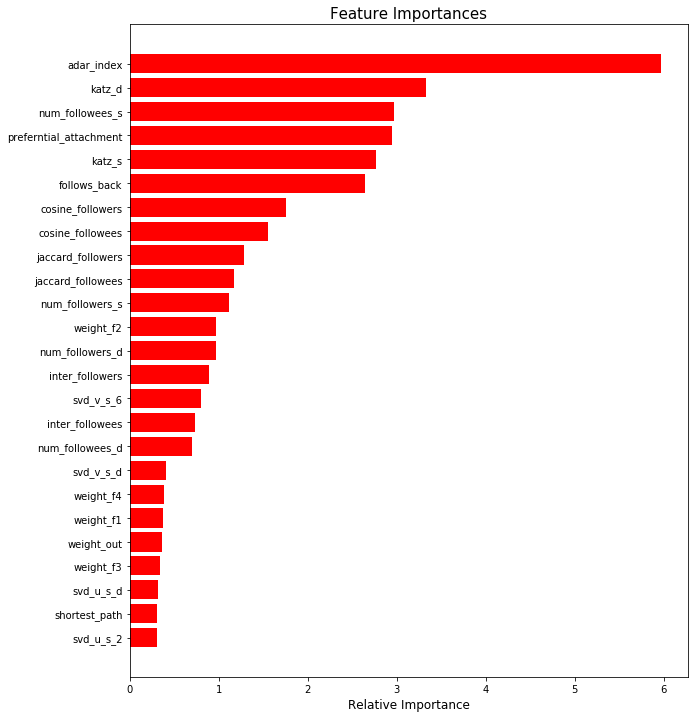

In [23]:
features = df_train.columns
importances = np.abs(clf.coef_)[0]
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances', fontsize = 15)
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance', fontsize = 12)
plt.show()

## 2.3 Decision Tree

For values of max_depth = 2, Train f1 score: 0.8969 and CV f1 score: 0.8911
For values of max_depth = 5, Train f1 score: 0.9287 and CV f1 score: 0.9169
For values of max_depth = 8, Train f1 score: 0.9558 and CV f1 score: 0.9145
For values of max_depth = 10, Train f1 score: 0.9641 and CV f1 score: 0.9208
For values of max_depth = 15, Train f1 score: 0.9724 and CV f1 score: 0.9202
For values of max_depth = 20, Train f1 score: 0.9832 and CV f1 score: 0.9174
For values of max_depth = 25, Train f1 score: 0.993 and CV f1 score: 0.9144
For values of max_depth = 30, Train f1 score: 0.9975 and CV f1 score: 0.9118
For values of max_depth = 40, Train f1 score: 0.9991 and CV f1 score: 0.9113
For values of max_depth = 50, Train f1 score: 0.9991 and CV f1 score: 0.9106
For values of max_depth = 80, Train f1 score: 0.9991 and CV f1 score: 0.9106
For values of max_depth = 100, Train f1 score: 0.9991 and CV f1 score: 0.9106



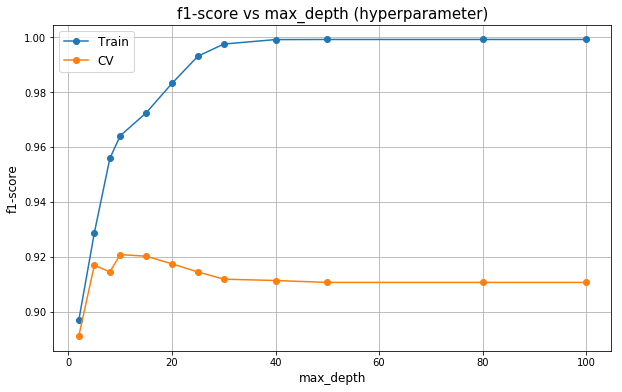

Best depth value is: 10 ,But need validation form plot!


In [24]:
cv_score, best_depth = DT_tunning(x_train, y_train, x_cv, y_cv)

f1-score for train:0.9641, CV:0.9208 and Test:0.9202
For train data


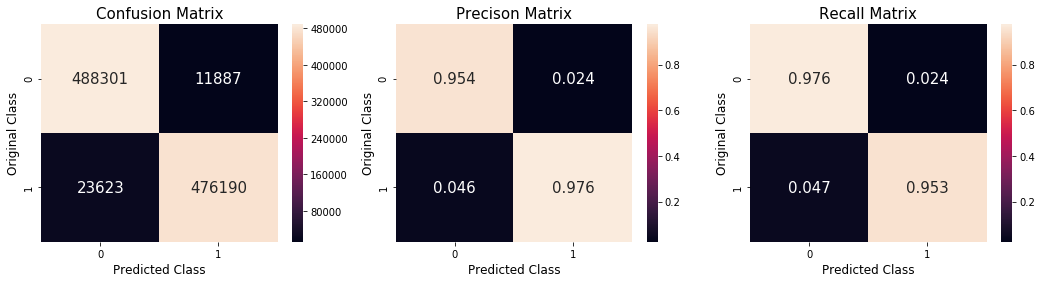

For CV data


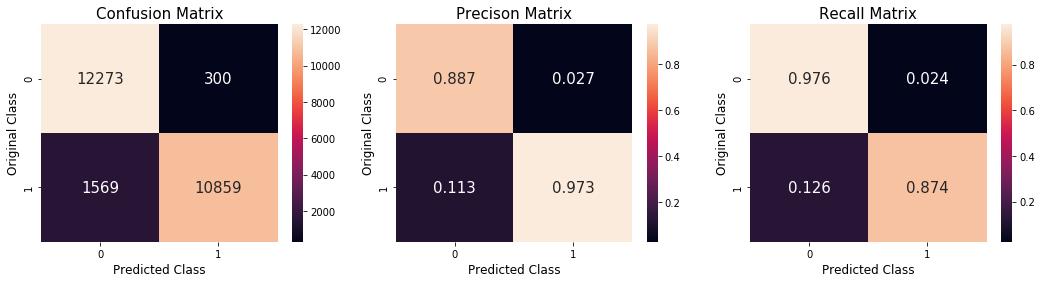

For test data


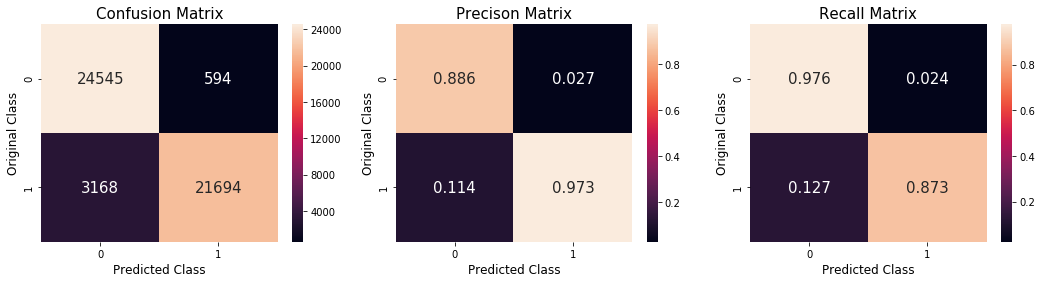

In [25]:
best_depth =  best_depth
clf = DecisionTreeClassifier(criterion = 'gini', max_depth = best_depth, random_state = 42)
train_score, cv_score, test_score, clf = report_classifier(clf, x_train, y_train, x_cv, y_cv, x_test, y_test)

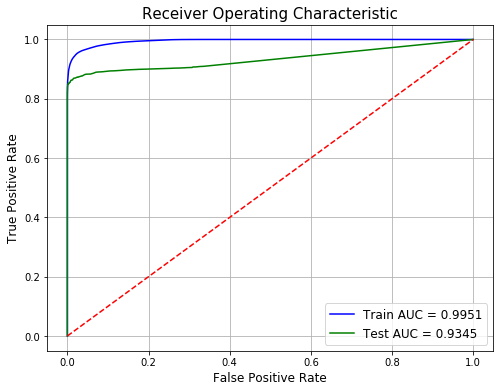

In [26]:
fpr_train, tpr_train, ths_train = roc_curve(y_train, clf.predict_proba(x_train)[:,1])
auc_train = round(auc(fpr_train, tpr_train),4)

fpr_test, tpr_test, ths_test = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
auc_test = round(auc(fpr_test, tpr_test),4)

table.add_row(['Decision Tree', train_score, cv_score, test_score, auc_train, auc_test])
plot_roc_curve(fpr_train, tpr_train, auc_train, fpr_test, tpr_test, auc_test)

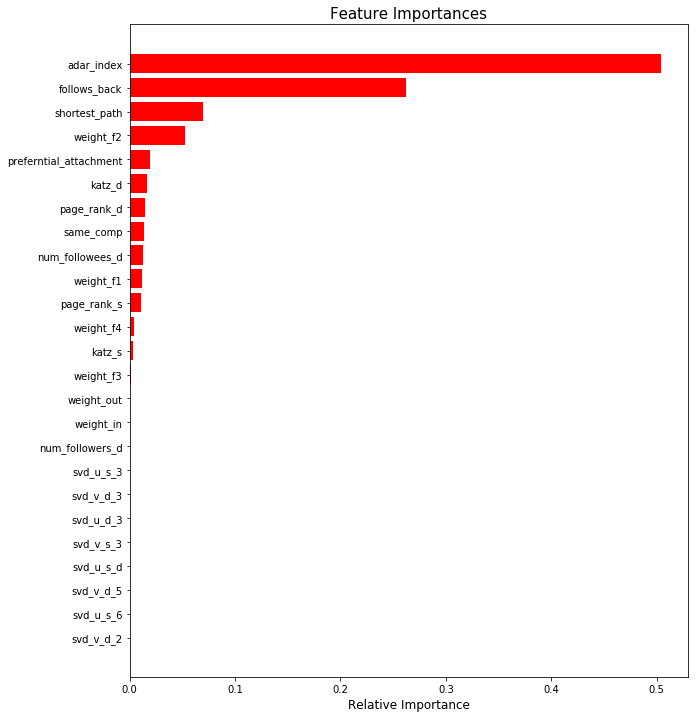

In [27]:
features = df_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]

plt.figure(figsize=(10,12))
plt.title('Feature Importances', fontsize = 15)
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance', fontsize = 12)
plt.show()

## 2.4 Random Forest

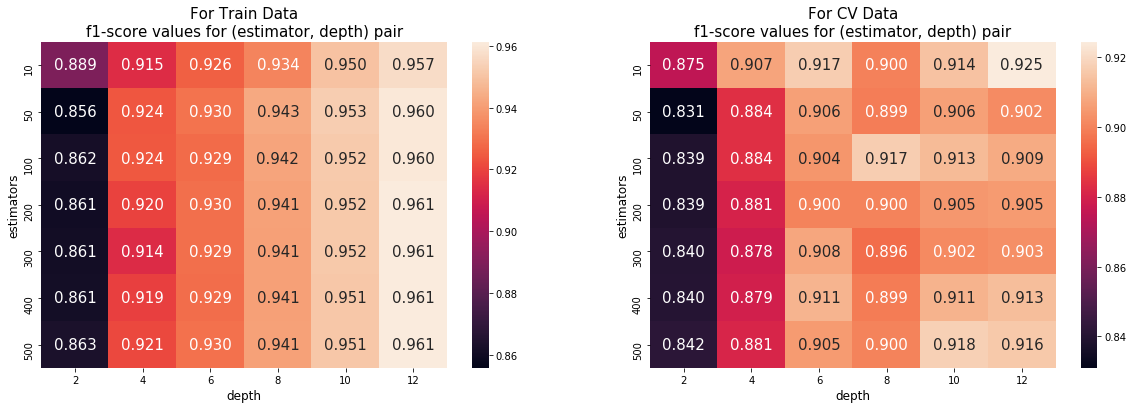

In [28]:
tune_RF(x_train, y_train, x_cv, y_cv)

f1-score for train:0.9709, CV:0.9331 and Test:0.9327
For train data


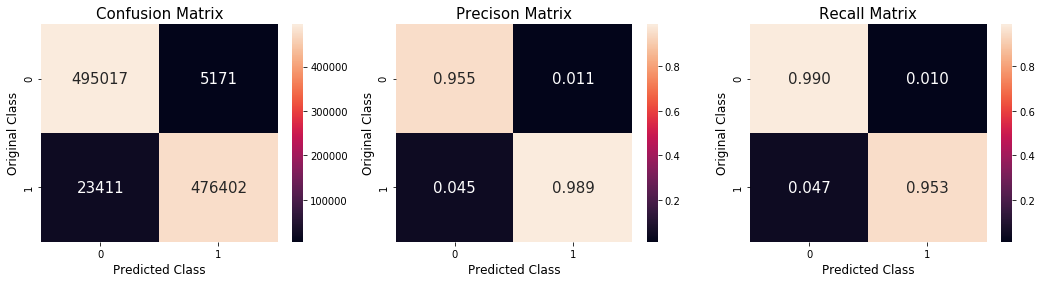

For CV data


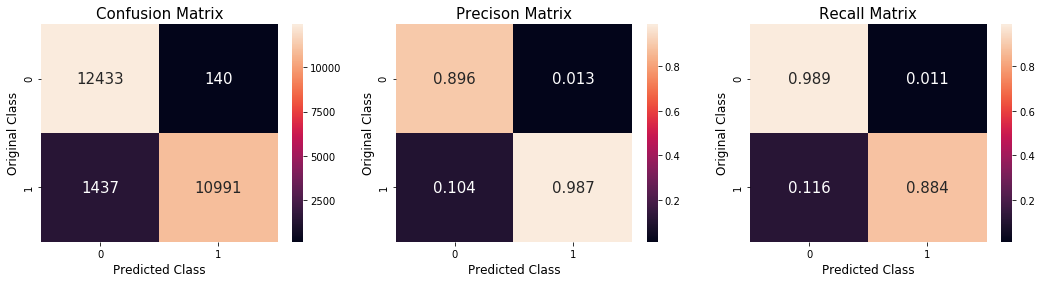

For test data


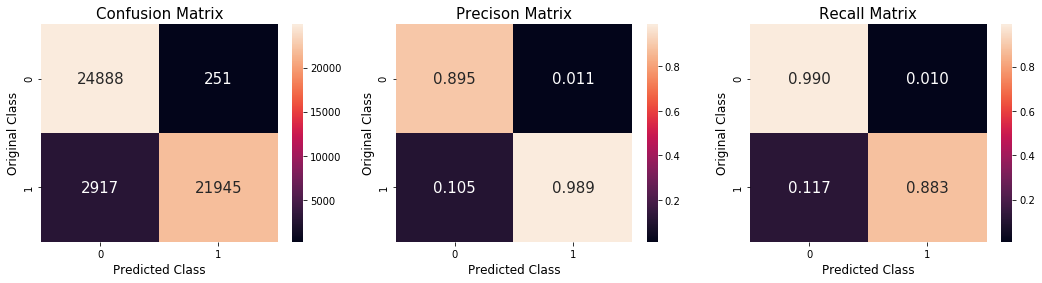

In [30]:
best_depth, best_est = 12, 10
clf = LGBMClassifier(boosting_type = 'gbdt', max_depth = best_depth, n_estimators= best_est, random_state = 42)
train_score, cv_score, test_score, clf = report_classifier(clf, x_train, y_train, x_cv, y_cv, x_test, y_test)

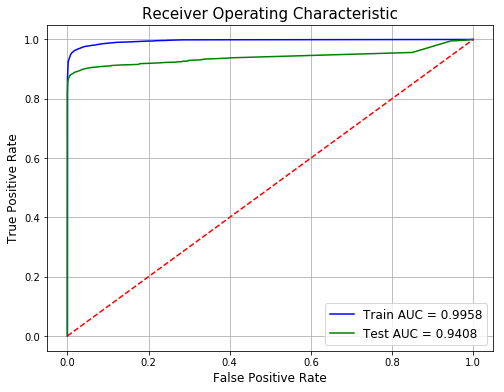

In [31]:
fpr_train, tpr_train, ths_train = roc_curve(y_train, clf.predict_proba(x_train)[:,1])
auc_train = round(auc(fpr_train, tpr_train),4)

fpr_test, tpr_test, ths_test = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
auc_test = round(auc(fpr_test, tpr_test),4)
table.add_row(['Random Forest', train_score, cv_score, test_score, auc_train, auc_test])

plot_roc_curve(fpr_train, tpr_train, auc_train, fpr_test, tpr_test, auc_test)

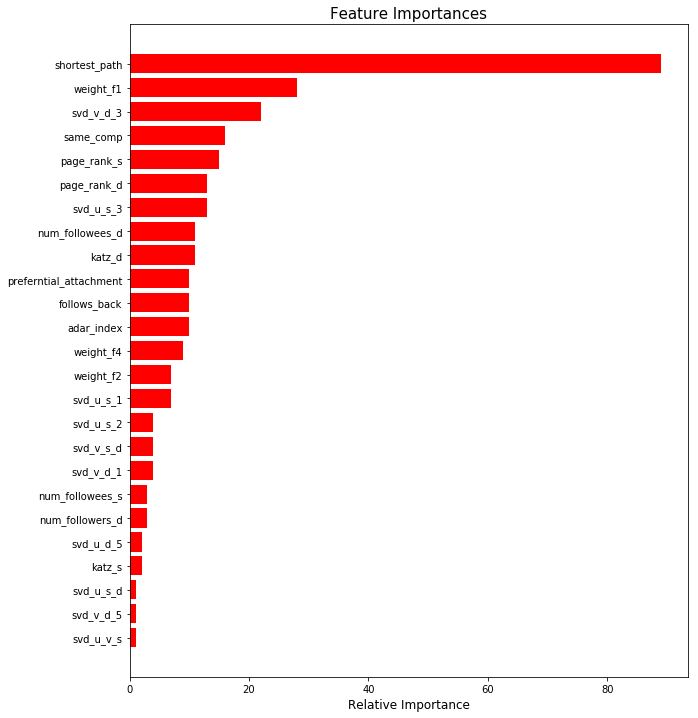

In [32]:
features = df_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]

plt.figure(figsize=(10,12))
plt.title('Feature Importances', fontsize = 15)
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance', fontsize = 12)
plt.show()

## 2.6 GBDT

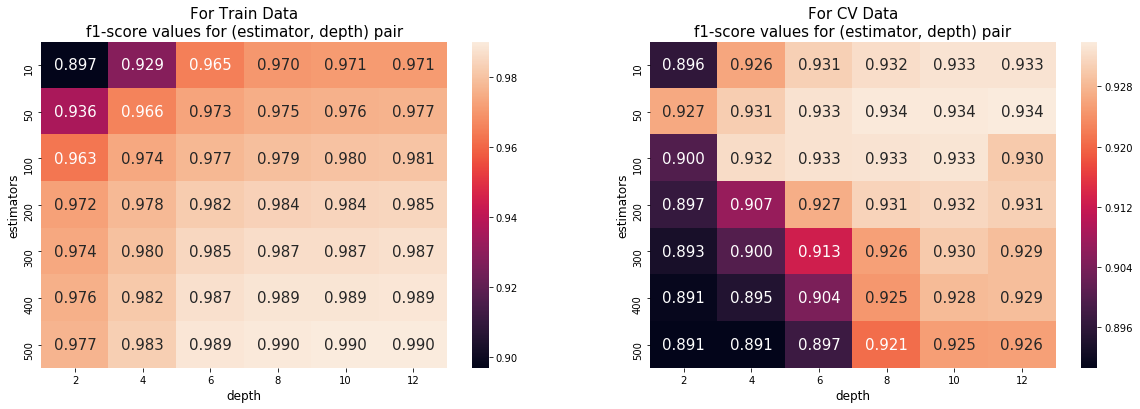

In [33]:
tune_GBDT(x_train, y_train, x_cv, y_cv)

f1-score for train:0.9754, CV:0.9336 and Test:0.9329
For train data


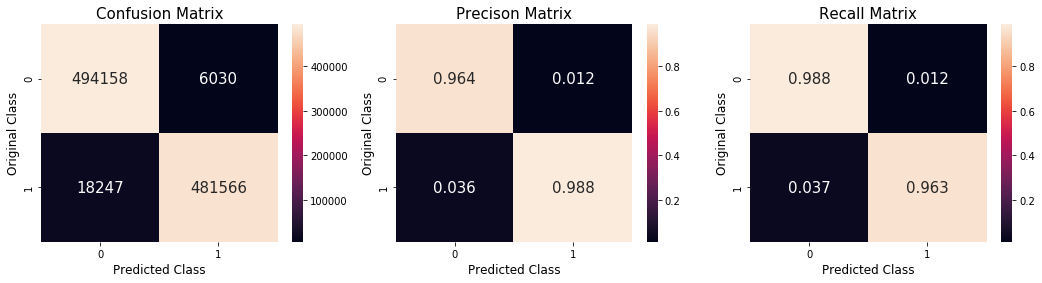

For CV data


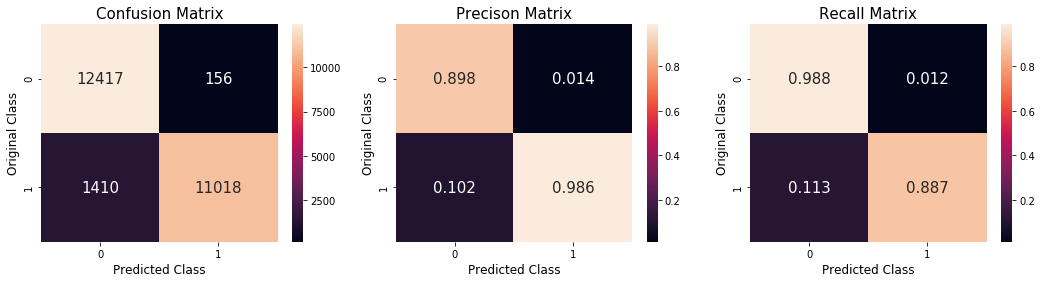

For test data


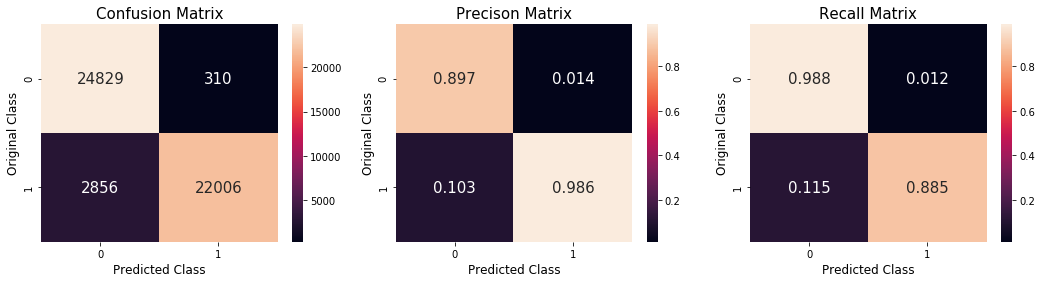

In [34]:
best_depth, best_est = 8, 50
clf = LGBMClassifier(boosting_type = 'gbdt', max_depth = best_depth, n_estimators= best_est, random_state = 42)
train_score, cv_score, test_score, clf = report_classifier(clf, x_train, y_train, x_cv, y_cv, x_test, y_test)

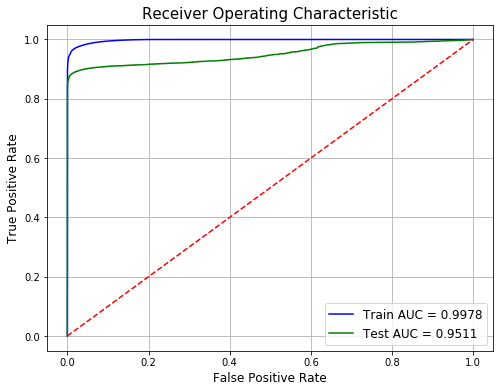

In [35]:
fpr_train, tpr_train, ths_train = roc_curve(y_train, clf.predict_proba(x_train)[:,1])
auc_train = round(auc(fpr_train, tpr_train),4)

fpr_test, tpr_test, ths_test = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
auc_test = round(auc(fpr_test, tpr_test),4)

table.add_row(['GBDT', train_score, cv_score, test_score, auc_train, auc_test])
plot_roc_curve(fpr_train, tpr_train, auc_train, fpr_test, tpr_test, auc_test)

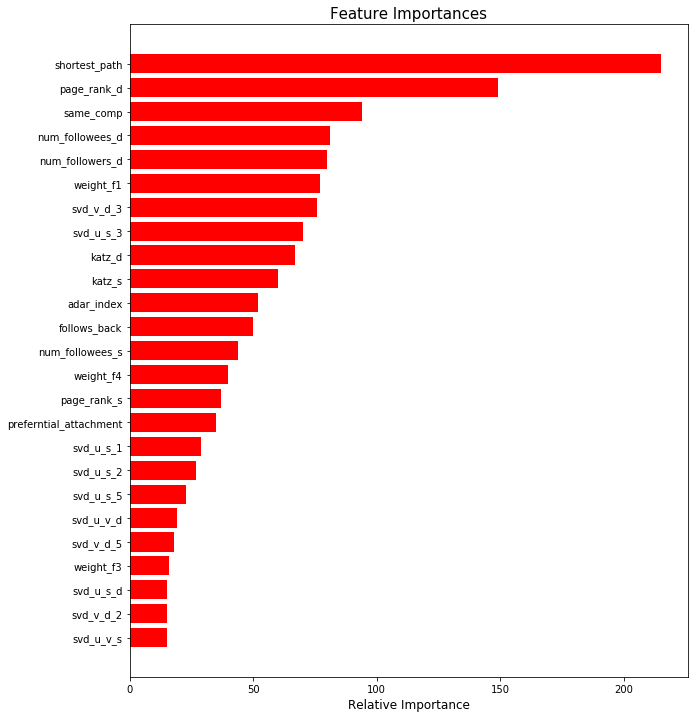

In [36]:
features = df_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]

plt.figure(figsize=(10,12))
plt.title('Feature Importances', fontsize = 15)
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance', fontsize = 12)
plt.show()

# 3. Conclusion

In [37]:
print(table)

+---------------------+----------------+-------------+---------------+-----------+----------+
|        Model        | Train f1-score | CV f1-score | Test f1-score | Train AUC | Test AUC |
+---------------------+----------------+-------------+---------------+-----------+----------+
| Logistic Regression |     0.9213     |    0.9122   |     0.9116    |   0.9812  |  0.9659  |
|      Linear SVM     |     0.921      |    0.9138   |     0.9139    |   0.982   |  0.9621  |
|    Decision Tree    |     0.9641     |    0.9208   |     0.9202    |   0.9951  |  0.9345  |
|    Random Forest    |     0.9709     |    0.9331   |     0.9327    |   0.9958  |  0.9408  |
|         GBDT        |     0.9754     |    0.9336   |     0.9329    |   0.9978  |  0.9511  |
+---------------------+----------------+-------------+---------------+-----------+----------+


In [39]:
# let's sort the pretty table by test log-loss value: https://ptable.readthedocs.io/en/latest/tutorial.html
print(table.get_string(sortby="Test f1-score", reversesort=True))

+---------------------+----------------+-------------+---------------+-----------+----------+
|        Model        | Train f1-score | CV f1-score | Test f1-score | Train AUC | Test AUC |
+---------------------+----------------+-------------+---------------+-----------+----------+
|         GBDT        |     0.9754     |    0.9336   |     0.9329    |   0.9978  |  0.9511  |
|    Random Forest    |     0.9709     |    0.9331   |     0.9327    |   0.9958  |  0.9408  |
|    Decision Tree    |     0.9641     |    0.9208   |     0.9202    |   0.9951  |  0.9345  |
|      Linear SVM     |     0.921      |    0.9138   |     0.9139    |   0.982   |  0.9621  |
| Logistic Regression |     0.9213     |    0.9122   |     0.9116    |   0.9812  |  0.9659  |
+---------------------+----------------+-------------+---------------+-----------+----------+


__Summary__
* Designed various feature for given data. There are many datapoints but I'm taking only 1m datapoints to train the model. 50k datapoint for testing and 25k datapoints for CV.
* After feature engineering various models are applied. Out of those models __GBDT__ and __Random Forest__ are giving almost same and highest __F1-score__.
* Simple models like __logistic regression__, __linear svm, and decision tree__ are also doing good jib.